# Dask Array in 3 minutes

// From https://www.youtube.com/watch?v=9h_61hXCDuI)

In [1]:
# https://stackoverflow.com/questions/59070260/dask-client-detect-local-default-cluster-already-running
import os
os.environ['DASK_SCHEDULER_ADDRESS'] = 'tcp://localhost:8787'

if not ("cluster" in globals() and "client" in globals()):
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster(dashboard_address=':8787')
    client = Client(cluster)
    print(client, client.dashboard_link)

2023-04-04 09:57:44,277 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-7uwrvxwd', purging


<Client: 'tcp://127.0.0.1:44923' processes=4 threads=8, memory=31.01 GiB> http://127.0.0.1:8787/status


## Small array

In [2]:
import numpy as np

x = np.ones(15)
x

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
import dask.array as da

x = da.ones(15, chunks=(5, ))
x

dask.array<ones_like, shape=(15,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>

In [ ]:
# The return type is a scalar.
x.sum()

In [4]:
# Dask is lazy by default.
x.sum().compute()

15.0

## Medium array

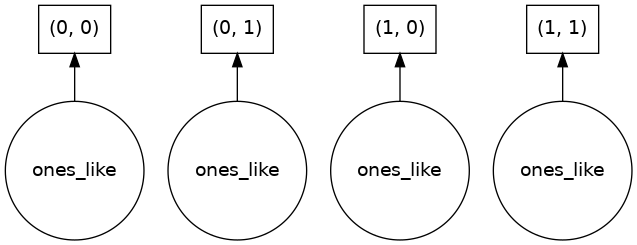

In [11]:
x = da.ones((10_000, 10_000), chunks=(5000, 5000))
x.visualize()

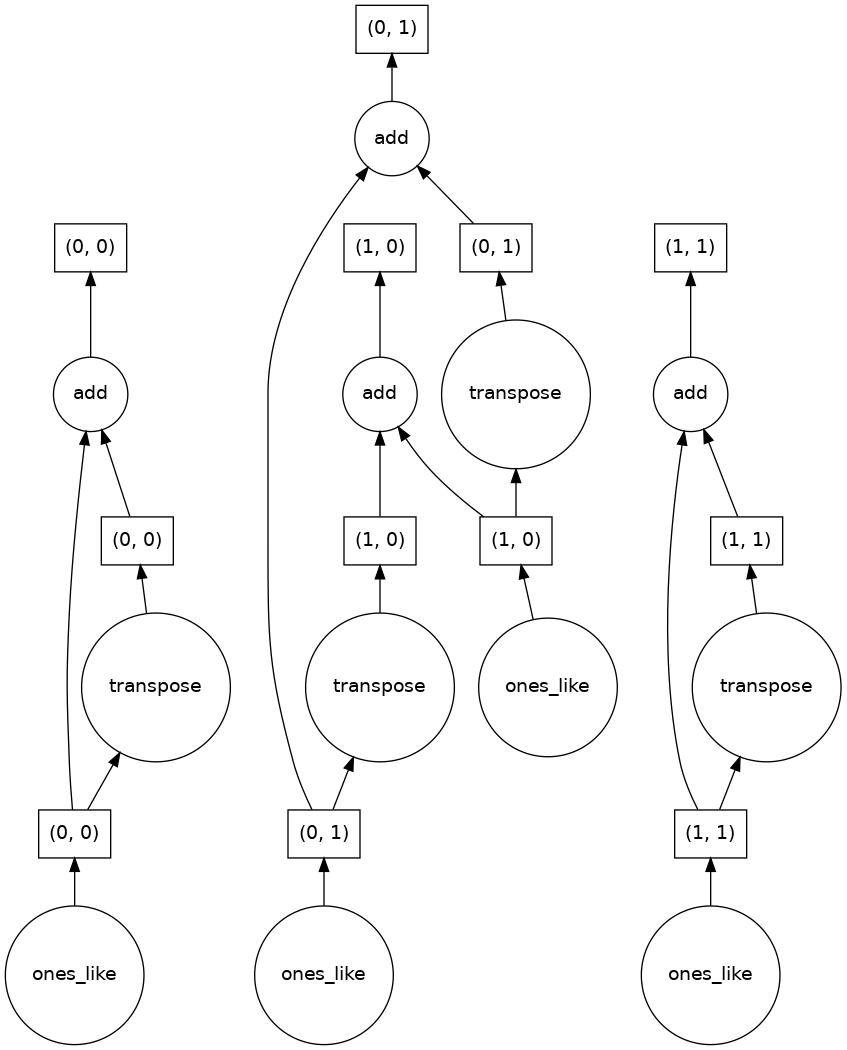

In [13]:
y = x + x.T

y.visualize()

In [14]:
y.compute()

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

## Larger array

In [6]:
x = da.ones((10_000, 10_000), chunks=(1000, 1000))
x

dask.array<ones_like, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

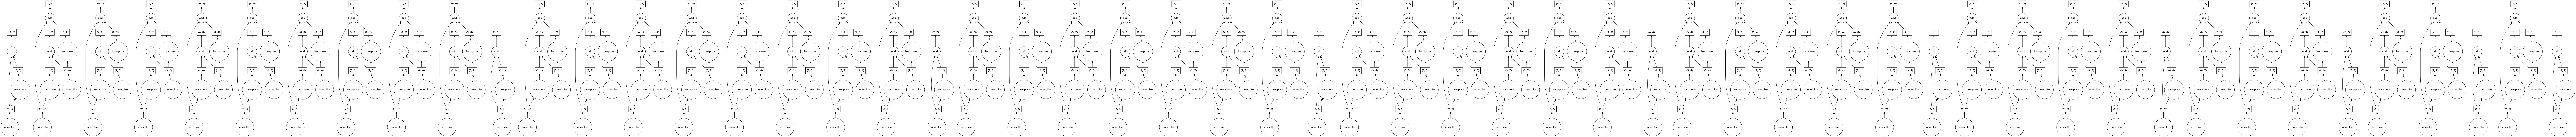

In [9]:
y = x + x.T

y.visualize()

In [ ]:
y.compute()